In [32]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Load the data
transactions=pd.read_csv("transactions.csv.txt",parse_dates=['date'])
cc_info=pd.read_csv("cc_info.csv.txt")

In [8]:
transactions.head()


,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [6]:
cc_info.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


### Question 1

Your boss wants to identify those users that in your dataset never went above the monthly credit card limit (calendar month). The goal of this is to automatically increase their limit. Can you send him the list of Ids?

In [17]:
df=pd.merge(cc_info,transactions,on='credit_card',how='left')
df.head()

,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat
0,1280981422329509,Dallas,PA,18612,6000,2015-08-05 00:59:19,11.94,-75.964527,41.353578
1,1280981422329509,Dallas,PA,18612,6000,2015-10-29 18:23:04,5.76,-76.019703,41.311467
2,1280981422329509,Dallas,PA,18612,6000,2015-10-25 17:50:48,25.84,-76.043031,41.291053
3,1280981422329509,Dallas,PA,18612,6000,2015-09-05 17:39:43,68.89,-75.944299,41.327282
4,1280981422329509,Dallas,PA,18612,6000,2015-09-04 14:12:59,27.01,-75.997259,41.352099


In [18]:
#Extracting day,month and year from date
df['Day']=df['date'].apply(lambda x: x.day)
df['month'] = df['date'].apply(lambda x: x.month)
df['year'] = df['date'].apply(lambda x: x.year)
df['weekday'] = df['date'].apply(lambda x: x.dayofweek)
df['hour'] = df['date'].apply(lambda x: x.hour)

df=df.drop(['date'],axis=1)
df.head()

,credit_card,city,state,zipcode,credit_card_limit,transaction_dollar_amount,Long,Lat,Day,month,year,weekday,hour
0,1280981422329509,Dallas,PA,18612,6000,11.94,-75.964527,41.353578,5,8,2015,2,0
1,1280981422329509,Dallas,PA,18612,6000,5.76,-76.019703,41.311467,29,10,2015,3,18
2,1280981422329509,Dallas,PA,18612,6000,25.84,-76.043031,41.291053,25,10,2015,6,17
3,1280981422329509,Dallas,PA,18612,6000,68.89,-75.944299,41.327282,5,9,2015,5,17
4,1280981422329509,Dallas,PA,18612,6000,27.01,-75.997259,41.352099,4,9,2015,4,14


In [13]:
#Checking the year of data
df['year'].value_counts()

2015    294588
Name: year, dtype: int64

Since the data is only for the year 2015, we can groupby on months directly to answer our question.

In [57]:
monthly_data= df.groupby(['credit_card','month']).agg({'transaction_dollar_amount':sum,'credit_card_limit':'first'}).reset_index()
monthly_data['exceed']=monthly_data['credit_card_limit']<monthly_data['transaction_dollar_amount'].astype(int)
grouped_sum = monthly_data.groupby('credit_card')['exceed'].sum().reset_index()

lists = grouped_sum[grouped_sum['exceed'] == 0][['credit_card']]

print('Valid users:\t', len(lists))
lists.head()

Valid users:	 862


,credit_card
0,1003715054175576
1,1013870087888817
2,1023820165155391
3,1073931538936472
4,1077622576192810


There are 862 valid users that have not exceeded their credit limit in any month.

### Question 2

On the other hand, she wants you to implement an algorithm that as soon as a user goes above her monthly limit, it triggers an alert so that the user can be notiﬁed about that.We assume here that at the beginning of the new month, user total money spent gets reset to zero (i.e. she pays the card fully at the end of each month). Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day.

In [60]:
monthly_data.head()

,credit_card,month,transaction_dollar_amount,credit_card_limit,exceed
0,1003715054175576,7,162.56,20000,False
1,1003715054175576,8,8441.51,20000,False
2,1003715054175576,9,11281.56,20000,False
3,1003715054175576,10,8954.21,20000,False
4,1013870087888817,7,281.43,15000,False


In [124]:
def invalid_user(day,month):
    data= df[(df['month']==month) & (df['Day'] <=day)]
    #print(data)
    data=data.groupby(['credit_card']).agg({'transaction_dollar_amount':sum,'credit_card_limit':min}).reset_index()
    #print(data[data.credit_card==1280981422329509])
    data['exceed']= data['transaction_dollar_amount']> data['credit_card_limit'].astype(int)
    v= data[data['exceed']=='True']
    
    return v

In [125]:
invalid_user(20,8)

,credit_card,transaction_dollar_amount,credit_card_limit,exceed


### Question 3

Finally, your boss is very concerned about frauds cause they are a huge cost for credit card companies. She wants you to implement an unsupervised algorithm that returns all transactions that seem unusual and are worth being investigated further.

#### Preparing Features

The factors that determine whether a transaction is a fraud or not are:

1. Unusual Transactions - If the transaction amount is much higher than what you usually pay using your credict card then  the transaction is most likely a fraudulent transaction.
2. Far off Location - If the transaction was made at a place that is far from your local address/ address around which you make purchases using your credit card then that can be classified as potential fraud.
3. Odd Times - Transactions made at odd times are also considered potential fraud.

In [6]:
df.head()

,credit_card,city,state,zipcode,credit_card_limit,transaction_dollar_amount,Long,Lat,Day,month,year,weekday,hour
0,1280981422329509,Dallas,PA,18612,6000,11.94,-75.964527,41.353578,5,8,2015,2,0
1,1280981422329509,Dallas,PA,18612,6000,5.76,-76.019703,41.311467,29,10,2015,3,18
2,1280981422329509,Dallas,PA,18612,6000,25.84,-76.043031,41.291053,25,10,2015,6,17
3,1280981422329509,Dallas,PA,18612,6000,68.89,-75.944299,41.327282,5,9,2015,5,17
4,1280981422329509,Dallas,PA,18612,6000,27.01,-75.997259,41.352099,4,9,2015,4,14


In [19]:
#Creating features to check unusual amounts:

#Feature 1: ratio of transaction over transaction median
median= df.groupby('credit_card')['transaction_dollar_amount'].median().reset_index()
median = median.rename(columns={'transaction_dollar_amount': 'median'})
df = pd.merge(left=df, right=median, on='credit_card', how='left')
df['transaction/median']= df['transaction_dollar_amount']/df['median']

#Feature 2: ratio of transaction 
df['transaction/credit_card_limit']=df['transaction_dollar_amount']/df['credit_card_limit']

In [20]:
df.head()

,credit_card,city,state,zipcode,credit_card_limit,transaction_dollar_amount,Long,Lat,Day,month,year,weekday,hour,median,transaction/median,transaction/credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000,11.94,-75.964527,41.353578,5,8,2015,2,0,34.37,0.347396,0.001990
1,1280981422329509,Dallas,PA,18612,6000,5.76,-76.019703,41.311467,29,10,2015,3,18,34.37,0.167588,0.000960
2,1280981422329509,Dallas,PA,18612,6000,25.84,-76.043031,41.291053,25,10,2015,6,17,34.37,0.751818,0.004307
3,1280981422329509,Dallas,PA,18612,6000,68.89,-75.944299,41.327282,5,9,2015,5,17,34.37,2.004364,0.011482
4,1280981422329509,Dallas,PA,18612,6000,27.01,-75.997259,41.352099,4,9,2015,4,14,34.37,0.785860,0.004502


In [22]:
#Creating features to check distance from home address

#address co ordinates= median of lat, median of long
address= df.groupby('credit_card').agg({'Lat':'median','Long':'median'}).reset_index()
address=address.rename(columns={'Lat':'Lat_median','Long':'Long_median'})
df=pd.merge(df,address,on='credit_card',how='left')

#calculating distance 
df['distance']= np.sqrt((df['Long']-df['Long_median'])**2 + (df['Lat']-df['Lat_median'])**2)

In [23]:
df.head()

,credit_card,city,state,zipcode,credit_card_limit,transaction_dollar_amount,Long,Lat,Day,month,year,weekday,hour,median,transaction/median,transaction/credit_card_limit,Lat_median,Long_median,distance
0,1280981422329509,Dallas,PA,18612,6000,11.94,-75.964527,41.353578,5,8,2015,2,0,34.37,0.347396,0.001990,41.346369,-75.971329,0.009912
1,1280981422329509,Dallas,PA,18612,6000,5.76,-76.019703,41.311467,29,10,2015,3,18,34.37,0.167588,0.000960,41.346369,-75.971329,0.059650
2,1280981422329509,Dallas,PA,18612,6000,25.84,-76.043031,41.291053,25,10,2015,6,17,34.37,0.751818,0.004307,41.346369,-75.971329,0.090560
3,1280981422329509,Dallas,PA,18612,6000,68.89,-75.944299,41.327282,5,9,2015,5,17,34.37,2.004364,0.011482,41.346369,-75.971329,0.033089
4,1280981422329509,Dallas,PA,18612,6000,27.01,-75.997259,41.352099,4,9,2015,4,14,34.37,0.785860,0.004502,41.346369,-75.971329,0.026556


In [25]:
# drop useless features
labels = ['transaction_dollar_amount', 'Long', 'Lat', 'city', 'state', 'zipcode', 'credit_card_limit', 
          'month', 'Day', 'Long_median', 'Lat_median', 'median']
df = df.drop(labels=labels, axis=1)
df.head()

,credit_card,year,weekday,hour,transaction/median,transaction/credit_card_limit,distance
0,1280981422329509,2015,2,0,0.347396,0.001990,0.009912
1,1280981422329509,2015,3,18,0.167588,0.000960,0.059650
2,1280981422329509,2015,6,17,0.751818,0.004307,0.090560
3,1280981422329509,2015,5,17,2.004364,0.011482,0.033089
4,1280981422329509,2015,4,14,0.785860,0.004502,0.026556


### Isolation Forest Model

There are different methods for unsupervised anomaly detection, such as Isolation Forest, One-Class SVM, DBSCAN, k means clustering,local outlier factor etc. Here, i have used the isolation forest algorithm.

In [28]:
#Scale your features as isolation forest is a distance based algorithm
from sklearn.preprocessing import StandardScaler
x=df.loc[:,df.columns!='credit_card']
scaler = StandardScaler()
X = scaler.fit_transform(x)


I have taken the contamination factor as 12% as in this case, as its better to identify few points which might be normal as anomalous(false positives) ,but not to miss out on catching an anomaly(true negative).

In [45]:
from sklearn.ensemble import IsolationForest
 
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12),max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(X)

pred = clf.predict(X)
df['anomaly']=pred
outliers=df.loc[df['anomaly']==-1]
outlier_index=list(outliers.index)

#Find the number of anomalies and normal points here points classified -1 are anomalous
print(df['anomaly'].value_counts())

 1    259237
-1     35351
Name: anomaly, dtype: int64


The algorithm identified 35351 transactions as anomalies.

In [41]:
#We can see which transactions are marked as anomalies by checking the anomaly column in the dataframe
df.head()

,credit_card,year,weekday,hour,transaction/median,transaction/credit_card_limit,distance,anomaly
0,1280981422329509,2015,2,0,0.347396,0.001990,0.009912,-1
1,1280981422329509,2015,3,18,0.167588,0.000960,0.059650,1
2,1280981422329509,2015,6,17,0.751818,0.004307,0.090560,1
3,1280981422329509,2015,5,17,2.004364,0.011482,0.033089,1
4,1280981422329509,2015,4,14,0.785860,0.004502,0.026556,1


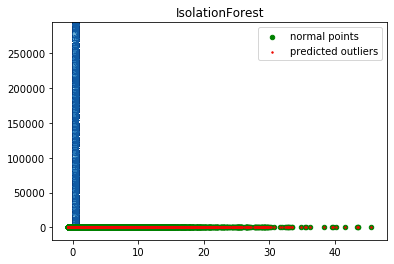

In [46]:
#Visualizing the plot
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
res=pd.DataFrame(pca.transform(X))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',edgecolor='red',s=2,label="predicted outliers")
plt.legend(loc="upper right")
plt.show()